In [1]:
import string
import re
import os
import nltk
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
SEED = 1013
np.random.seed(SEED)
#nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, twitter_samples 
from stance_utils import *
from stance_models import * 
#from parameters import *
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Dropout,Concatenate,Dense, Embedding, SpatialDropout1D, Flatten, GRU, Bidirectional, Conv1D,MaxPooling1D

from tensorflow.keras.layers import RNN, Dropout,Concatenate,Dense, Embedding,LSTMCell, LSTM, SpatialDropout1D, Flatten, GRU, Bidirectional, Conv1D, Input,MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from sklearn.model_selection import StratifiedKFold
stemmer = PorterStemmer()
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stopwords_english = stopwords.words('english')
from sklearn.preprocessing import LabelEncoder
import keras.backend as K
from keras.layers import Lambda
import random
import matplotlib.pyplot as plt
import time
start_time = time.time()

classes = {'FAVOR': np.array([1, 0, 0]), 'AGAINST': np.array([0, 1, 0]), 'NONE': np.array([0, 0, 1])}
classes_ = np.array(['FAVOR', 'AGAINST', 'NONE'])

# train_data_file = '/data/parush/stance_mohammed/new_train.txt'
# test_data_file = '/data/parush/stance_mohammed/new_test.txt'
# TARGETS = [ 'Atheism','Climate Change is a Real Concern', 'Feminist Movement','Hillary Clinton', 'Legalization of Abortion', 'Donald Trump']


train_data_file = '/data/parush/SomasundaranWiebe-politicalDebates/train.txt'
test_data_file = '/data/parush/SomasundaranWiebe-politicalDebates/test.txt'
TARGETS = ['god','healthcare','guns','gayRights','abortion', 'creation']


# train_data_file = '/data/parush/Data_MPCHI/train.txt'
# test_data_file = '/data/parush/Data_MPCHI/test.txt'
# TARGETS = ['Are E-Cigarettes safe?','Does MMR Vaccine lead to autism in children?',
#       'Does Sunlight exposure lead to skin cancer?','Does Vitamin C prevent common cold?',
#       'Should women take HRT post-menopause?']

#target = TARGETS[0]

def train_and_test(train_file, test_file, target):
    
    
    sentence_maxlen = 0
    target_maxlen = 0
    x_s_token = []
    x_t_token = []
    y_train = []

    
    with open(train_file, 'r') as trainfile:
        
        for line in trainfile: 
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
            
            
            
            #if line[0].strip() != 'ID' and target in line[1].strip():
            if line[0].strip() != 'ID':  #Uncomment this line if training on wholedataset and comment the line above.
                tweet = line[2]
                tweet = process_tweet(tweet)
                if len(tweet) > sentence_maxlen:
                    sentence_maxlen = len(tweet)
                x_s_token.append(tweet)
                target_ = line[1].strip().lower().split()
                if len(target_) > target_maxlen:
                    target_maxlen = len(target_)
                x_t_token.append(target_)
                y_train.append(classes[line[3].strip()])
    c_len = len(x_s_token)
    print("Current x_s_token len is: ", c_len)
                
#     with open('rich_data/dt_ath_hc/Donald Trump_Atheism_Hillary Clinton0.5.txt','r') as new_file:
#         for line in new_file:
#             line = line.replace('#SemST', '').strip()
#             line = line.split('\t')
#             tweet = line[0]
#             tweet = process_tweet(tweet)
#             if len(tweet) > sentence_maxlen:
#                 sentence_maxlen = len(tweet)
#             x_s_token.append(tweet)
#             x_t_token.append(target_)
#             y_train.append(classes[line[1].strip()])
#     print("Added {} more examples".format(len(x_s_token)-c_len))
#     print("Total tweet {} and labels {}".format(len(x_s_token), len(y_train)))
        
    

                
    

                               
    
    x_s_test_token = []
    x_t_test_token = []
    y_test = []
    with open(test_file, 'r') as testfile:
        for line in testfile:
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
        

            
            #if line[0] != 'ID' and target in line[1].strip():
            if line[0].strip() != 'ID': #Uncomment this line if testing on wholedataset and comment the line above.
                tweet = line[2]
                tweet = process_tweet(tweet)
                if len(tweet) > sentence_maxlen:
                    sentence_maxlen = len(tweet)
                x_s_test_token.append(tweet)
                target_ = line[1].strip().lower().split()
                if len(target_) > target_maxlen:
                    target_maxlen = len(target_)
                x_t_test_token.append(target_)
                y_test.append(classes[line[3].strip()])


    
    return x_s_token, x_t_token, x_s_test_token, x_t_test_token, y_train, y_test, sentence_maxlen, target_maxlen


for target in TARGETS:
    start_time = time.time()
    

    batch_size = 16
    units = 60
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    num_classes = 3
    bicondORnot = False # Set True in case of using bicond model
    
    x_s_token, x_t_token, _, _, y_train, _, sentence_maxlen, target_maxlen  = train_and_test(train_data_file, test_data_file, target)
    _, _, x_s_test_token, x_t_test_token, _, y_test, _, _  = train_and_test(train_data_file, test_data_file, target)
    vocabulary = build_vocab(x_s_token + x_t_token )
    vocab_size = len(vocabulary)
    print("Total words in vocab are",vocab_size)
    embedding_matrix = get_embeddings('twitter',100,vocabulary)
    print('X_S_token {}, y_train {}, y_test {}'.format(len(x_s_token), len(y_train), len(y_test)))
    
    if bicondORnot:
        y_train = np.asarray(y_train)
        _,balance = divmod(len(y_train),batch_size)
        balance = batch_size-balance
        y_train = list(y_train)
        for i in range(balance):
            index = np.random.randint(1, len(y_train))
            x_s_token.append(x_s_token[index])
            y_train.append(y_train[index])
            x_t_token.append(x_t_token[index])
            
                
                    
     
            
            
    x_s = [tweet_to_tensor(each_s,vocabulary) for each_s in x_s_token]
    x_s = pad_sequences(x_s, maxlen = sentence_maxlen, padding = 'post')
    x_s_test = [tweet_to_tensor(each_s,vocabulary) for each_s in x_s_test_token]
    x_s_test = pad_sequences(x_s_test, maxlen = sentence_maxlen, padding = 'post')

    x_t = [tweet_to_tensor(each_s,vocabulary) for each_s in x_t_token]
    x_t = pad_sequences(x_t, maxlen = sentence_maxlen, padding = 'post')
    x_t_test = [tweet_to_tensor(each_s,vocabulary) for each_s in x_t_test_token]
    x_t_test = pad_sequences(x_t_test, maxlen = sentence_maxlen, padding = 'post')
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    x_s = x_s[shuffle_indices]
    x_t = x_t[shuffle_indices]
    y_train = np.asarray(y_train)
    y_train = y_train[shuffle_indices]
    y_test = np.asarray(y_test)
    
    # Select the model from below......
    
    print('X_S {}, y_train {}, y_test {}'.format(len(x_s), len(y_train), len(y_test)))
    #model = biGRU(embedding_matrix, num_classes)
    #model = biGRUCNN(embedding_matrix, num_classes,sentence_maxlen)
    #model = biLSTM(embedding_matrix, num_classes)
    model = biLSTMCNN(embedding_matrix, num_classes,sentence_maxlen)
    #model = bicond(units, opt, embedding_matrix, x_t, batch_size, sentence_maxlen,num_classes)
    print('Training {} on {}'.format(model.name, target))
    

    
    if model.name == 'bicond': # making test_set % batch_size = 0 and validation_split % batch_size = 0
        v_num = len(y_train)//10 
        _, b3 = divmod(v_num,16)
        v_split = (v_num  + (batch_size-b3)) / len(y_train)
        history = model.fit(x_s, y_train, epochs = 50, batch_size = batch_size,validation_split = v_split,  verbose=0)
        l = len(x_s_test)
        _, balance2 = divmod(l,batch_size)
        x_s_test = list(x_s_test)
        fill_number = batch_size - balance2
        for i in range(fill_number):
            x_s_test.append(np.zeros(sentence_maxlen,))
            
        x_s_test = np.array(x_s_test)
        y_pred = np.round(model.predict(x_s_test, batch_size = 16))
        print('Training {} on {}'.format(model.name, target))
        print(classification_report(y_test, y_pred[:-fill_number], digits=4, labels = [0,1]))
        break
    else:
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        cvscores = []

        for train, val in kfold.split(x_s, classes_[y_train.argmax(1)]):
            history = model.fit(x_s[train], y_train[train], epochs = 50, batch_size = batch_size, verbose=0)
            scores = model.evaluate(x_s[val], y_train[val], verbose=0)
            print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
            cvscores.append(scores[1] * 100)
        print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

        y_pred = np.round(model.predict(x_s_test))
        print('Training {} on {}'.format(model.name, target))
        print(classification_report(y_test, y_pred, digits=4, labels = [0,1]))
        print("--- %s seconds ---" % (time.time() - start_time))
    break
    


Current x_s_token len is:  4991
Current x_s_token len is:  4991
Total words in vocab are 20574
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
X_S_token 4991, y_train 4991, y_test 2141
X_S 4991, y_train 4991, y_test 2141


2022-07-13 21:12:37.077017: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 21:12:38.550058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43680 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-07-13 21:12:38.552036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43680 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-07-13 21:12:38.553881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43680 MB

Training model on god


2022-07-13 21:12:39.304081: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-13 21:12:41.886212: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-07-13 21:12:43.430346: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


accuracy: 61.66%
accuracy: 94.49%
accuracy: 99.40%
accuracy: 99.70%
accuracy: 99.80%
91.01% (+/- 14.81%)
Training model on god
              precision    recall  f1-score   support

           0     0.6515    0.6482    0.6498      1211
           1     0.5449    0.5484    0.5466       930

   micro avg     0.6049    0.6049    0.6049      2141
   macro avg     0.5982    0.5983    0.5982      2141
weighted avg     0.6052    0.6049    0.6050      2141
 samples avg     0.6049    0.6049    0.6049      2141

--- 2927.7373921871185 seconds ---


#### {90: , 80:, 70:, 60:, 50:}

KeyError: 'val_loss'

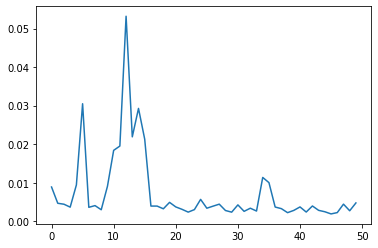

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# cvscores = []

# for train, val in kfold.split(x_s, classes_[y_train.argmax(1)]): 
#     model2.fit(x_s[train], y_train[train], epochs = 5, batch_size = 16, verbose=1)
# #     scores = model2.evaluate(x_s[val], y_train[val], verbose=0)
# #     print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))
# #     cvscores.append(scores[1] * 100)
# # print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))





In [ ]:
#embeddings_weights = get_embeddings('wikipedia',300,vocabulary)


In [ ]:
# Do we have to do this?
# x_s_ = tf.convert_to_tensor(
#     x_s_, dtype=tf.float32, dtype_hint=None, name=None
# )

In [ ]:
# i = 0
# j = 16
# while j<=640:
#     inputs = x_t[i:j]
#     lstm = LSTM(128, return_sequences=True, return_state=True)
#     whole_seq_output, h_0, c_0 = lstm(inputs,initial_state = [h_0, c_0])
#     i += 16
#     j += 16



In [ ]:
# inputs = Input(batch_shape=(16,1,18))
# lstm = LSTM(128, return_sequences=True, return_state=True)
# whole_seq_output, h_0, c_0 = lstm(inputs)
# model = Model(inputs=inputs, outputs=whole_seq_output)
# k = model.predict(x_t[:640])

In [ ]:
# final_memory_state = tf.reshape(
#     final_memory_state, (16,1,128), name=None
# )

# final_carry_state = tf.reshape(
#     final_carry_state, (16,1,128), name=None
# )


In [ ]:

# inputs2 = Input(shape=(1,sentence_maxlen,), name = 'Input')
# #embedded_inputs = Embedding(embeddings_weights.shape[0], embeddings_weights.shape[1], weights=[embeddings_weights], name = 'Embedding')(inputs2)
# #embedded_inputs2 = Dropout(0.2)(embedded_inputs)
# lstm, s1,s2 = LSTM(128,return_sequences=True,return_state=True,dropout=0.3,name = 'lstm')(inputs2, initial_state = i_states)
# #lstm = LSTM(128,return_sequences=True,dropout=0.3,name = 'lstm')(inputs2)
# flat = Flatten(name = 'Flatten')(lstm)
# output = (Dense(3,activation='softmax',name = 'Dense'))(flat)
# model2 = Model(inputs=inputs2, outputs=output)
# model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])    
# model2.summary()


In [ ]:
# x_t =np.array( [x.reshape(1,18) for x in x_t[:640]])

# x_t = tf.convert_to_tensor(
#     x_t, dtype=tf.float32, dtype_hint=None, name=None
# )

# inputs_list = [tf.squeeze(x) for x in
#                 tf.split(1, sentence_maxlen, embedded_inputs)]